### Image Prediction Capstone project

Below is my attempt to use two dataframes, one with a bunch of numerical image creation rows of brain scans and another which confirms the locations of tumors within the brain. I will be learning the brain images and identify how I can display, condense, locate and predict their locations. 

In [3]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [4]:
os.listdir("Data")

['braintumor_df.csv', 'image_df.csv']

In [5]:
df = pd.read_csv('Data/braintumor_df.csv')
df.sample(5) # BrainTumor df consists of the cordinate location of tumor selection in relation to image_df

,corner_x,corner_y,width,height
113,50,43,23,21
1696,60,45,49,63
1920,48,66,22,22
1417,62,90,13,15
1043,17,53,34,34


In [6]:
df.info() # 2500 rows non-nulls all INTs, no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   corner_x  2500 non-null   int64
 1   corner_y  2500 non-null   int64
 2   width     2500 non-null   int64
 3   height    2500 non-null   int64
dtypes: int64(4)
memory usage: 78.3 KB


In [7]:
idf = pd.read_csv('Data/image_df.csv')
idf.sample(5)

# 2500 separate images of cancer brain scans, one in each row.
# 128x128 images result in a total of 16,384 pixels (128*128 = 16,384).

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
474,0,0,0,0,0,0,0,0,0,0,...,43,38,34,32,32,0,0,0,0,0
1681,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,251,0,5,4,...,0,0,0,0,0,0,0,0,0,0
813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
idf.max().max() # highest value of a cell is 255 RGB (Red, Green, Blue)

255

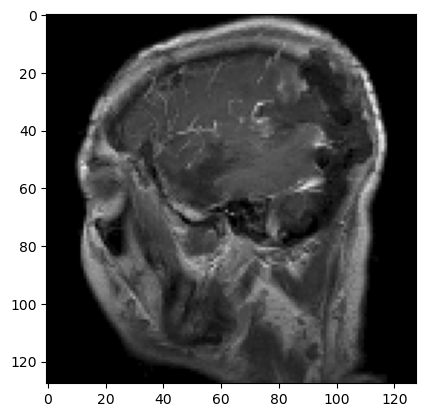

In [9]:
image = idf.iloc[0].values.reshape(128, 128) # retrieving first image from first idf row & making into 128x128 array
plt.imshow(image, cmap='gray')
plt.show()

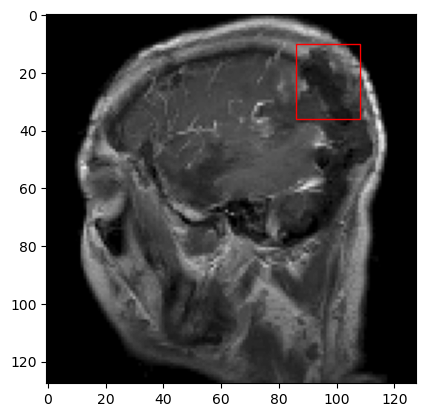

In [10]:
# Plotting the bounding box on the image from df
fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

x, y, w, h = df.iloc[0]  # Extracting coordinates and dimensions of bounding 
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none') # rectangle patch with width and height
ax.add_patch(rect)
plt.show()

In [11]:
# Above we have successfully displayed an image and overlayed the information from df to spesify where the brain tumor is in this image.
# Below we now start data-preprocessing and model analysis.

In [12]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score
import joblib

## Data-Preprocessing

In [14]:
image_data = np.array([img.reshape(128, 128) for img in idf.values]) # Preparing image data for model training
image_data = image_data / 255.0  # Normalizing pixel values from 0 to 1 so its easier to calculate

# Model:

In [16]:
X = image_data.reshape(image_data.shape[0], -1) # flatten the images again for input into your model.
y = df.values # 2D array 

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [18]:
multi_output_models = {
    'SVR': MultiOutputRegressor(SVR()),
    'Random Forest': RandomForestRegressor(),
    'KNN': MultiOutputRegressor(KNeighborsRegressor()),
    'Linear Regression': LinearRegression()
}

# PCA is used reduce dimensionality on training data, not using this takes too long to load.
n_components_list = [50, 100, 200] 

for n_components in n_components_list:
    pca = PCA(n_components=n_components) 
    X_reduced_train = pca.fit_transform(X_train)
    X_reduced_test = pca.transform(X_test)
    
    # Evaluate models with this reduced dimensionality
    for name, model in multi_output_models.items():
        model.fit(X_reduced_train, y_train)
        y_pred = model.predict(X_reduced_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f'{name} with {n_components} PCA components - MSE: {mse}, MAE: {mae}')


SVR with 50 PCA components - MSE: 208.3178732245347, MAE: 10.94222730808049
Random Forest with 50 PCA components - MSE: 110.15503933239, MAE: 7.399592015873014
KNN with 50 PCA components - MSE: 176.93312000000006, MAE: 9.071999999999996
Linear Regression with 50 PCA components - MSE: 205.72369378407063, MAE: 10.939686732617247
SVR with 100 PCA components - MSE: 211.65987875637475, MAE: 11.04330741030249
Random Forest with 100 PCA components - MSE: 112.64016338111608, MAE: 7.501034505901506
KNN with 100 PCA components - MSE: 162.60005333333334, MAE: 8.720533333333332
Linear Regression with 100 PCA components - MSE: 196.3723404995306, MAE: 10.61662713615359
SVR with 200 PCA components - MSE: 214.5933078924243, MAE: 11.144157151085704
Random Forest with 200 PCA components - MSE: 117.00736794893119, MAE: 7.680671164021163
KNN with 200 PCA components - MSE: 160.03061333333335, MAE: 8.664266666666666
Linear Regression with 200 PCA components - MSE: 188.14681227217304, MAE: 10.256026732114318

In [19]:
# Random Forest consistently outperformed other models, achieving the lowest MSE and MAE,  MSE: 110.86639015262114, MAE: 7.388595281926406 (0.2 test size)
# particularly with 50 PCA components, making it best option. 
# While increasing the number of PCA components improved KNN and Linear Regression, they still underperformed compared to Random Forest. 
# Using 50 PCA components with Random Forest provides a good balance between performance and computational efficiency.

In [20]:
# Commit PCA value 50
pca = PCA(n_components=50) 
X_reduced_train = pca.fit_transform(X_train)
X_reduced_test = pca.transform(X_test)

# RandomSearchCV

In [22]:
# I will use RandomSearchCV to further improve and hyperparameterize RandomForrest.

In [23]:
# Use RandomizedSearchCV for Random Forest
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_random_search = RandomizedSearchCV(RandomForestRegressor(), param_dist, n_iter=16, cv=5, n_jobs=-1, random_state=0)
rf_random_search.fit(X_reduced_train, y_train)

# Save and load the best model
best_rf = rf_random_search.best_estimator_
joblib.dump(best_rf, 'best_rf_model.pkl')
loaded_model = joblib.load('best_rf_model.pkl')

# Evaluate optimized Random Forest
X_reduced_test = pca.transform(X_test)
y_pred_rf = best_rf.predict(X_reduced_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Optimized Random Forest - MSE: {mse_rf}, MAE: {mae_rf}')
print(f'Best params: {rf_random_search.best_params_}')

Optimized Random Forest - MSE: 108.64996961623474, MAE: 7.369237645502645
Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [24]:
# Score sometimes only get's a little better or a little worse, suggests overfitting is an issue here..

In [25]:
best_params = rf_random_search.best_params_ 

In [26]:
# Save best model
joblib.dump(best_params, 'best_model.pkl')

['best_model.pkl']

## SVR Tuning:

In [28]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 0.2]
}

grid_search_svr = GridSearchCV(MultiOutputRegressor(SVR()), param_grid, cv=5, n_jobs=-1)
grid_search_svr.fit(X_reduced_train, y_train)

best_svr = grid_search_svr.best_estimator_
joblib.dump(best_svr, 'best_svr_model.pkl')
loaded_svr_model = joblib.load('best_svr_model.pkl')

# Evaluate optimized SVR
y_pred_svr = loaded_svr_model.predict(X_reduced_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

print(f'Optimized SVR - MSE: {mse_svr}, MAE: {mae_svr}')
print(f'Best params: {grid_search_svr.best_params_}')

Optimized SVR - MSE: 153.36603888433788, MAE: 8.562961500668578
Best params: {'estimator__C': 10, 'estimator__epsilon': 0.2, 'estimator__kernel': 'rbf'}


In [29]:
# SVR not worth investigating as it performed worse than RandomForrest.

# Imaging
I will fetch the first image and then predict where tumor would be

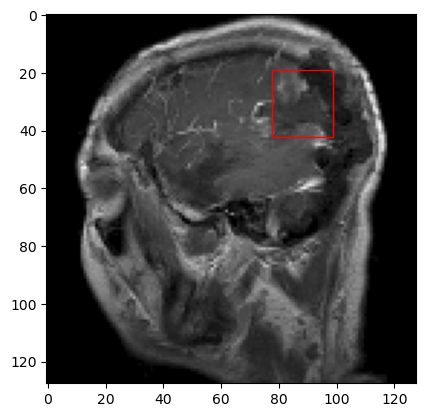

In [31]:
new_image = idf.iloc[0].values 
new_image = new_image.reshape(1, -1)  # Flatten the image to 1D array
new_image_normalized = new_image / 255.0  # Normalize image with pixel values between 0 and 1

# Apply PCA 
new_image_reduced = pca.transform(new_image_normalized)  # Reduce dimensions using same PCA

# Predicting box using the trained Random Forest model
predicted_bbox = rf_random_search.predict(new_image_reduced)  # Predict bounding box coordinates and size
x_pred, y_pred, w_pred, h_pred = predicted_bbox[0]  # Unpack predicted bounding box values

# Reshape the image for visualization
new_image_reshaped = new_image_normalized.reshape(128, 128)  # Reshape image back to 128x128 to display

fig, ax = plt.subplots(1) 
ax.imshow(new_image_reshaped, cmap='gray')

# layout predicted bounding box onto image
rect_pred = patches.Rectangle((x_pred, y_pred), w_pred, h_pred, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect_pred) 
plt.show() 

### Calculate distance from error

In [33]:
actual_bbox = df.iloc[0].values # Get the bounding box values from df
x_actual, y_actual, w_actual, h_actual = actual_bbox

# Calculate errors
x_error = abs(x_pred - x_actual)
y_error = abs(y_pred - y_actual)
w_error = abs(w_pred - w_actual)
h_error = abs(h_pred - h_actual)

print(f"X Error: {x_error}")
print(f"Y Error: {y_error}")
print(f"Width Error: {w_error}")
print(f"Height Error: {h_error}")

X Error: 8.316249999999997
Y Error: 8.98125
Width Error: 0.870000000000001
Height Error: 2.8687499999999986


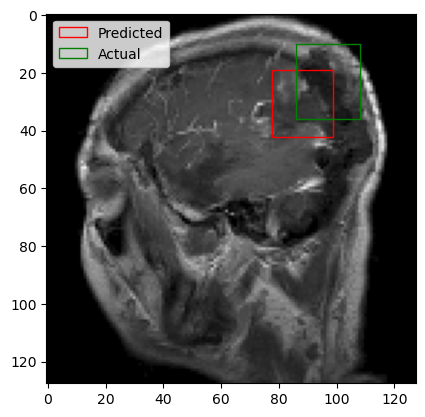

In [34]:
# Show error visually
fig, ax = plt.subplots(1) 
ax.imshow(new_image_reshaped, cmap='gray')

# Draw predicted bounding box
rect_pred = patches.Rectangle((x_pred, y_pred), w_pred, h_pred, linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
ax.add_patch(rect_pred)

# Actual bounding box
rect_actual = patches.Rectangle((x_actual, y_actual), w_actual, h_actual, linewidth=1, edgecolor='g', facecolor='none', label='Actual')
ax.add_patch(rect_actual)

ax.legend(['Predicted', 'Actual'])
plt.show()

# Attempt prediction on 10 different images.

In [84]:
def visualize_image_comparison(image, pred_bbox, actual_bbox):
    """Visualize an image with predicted and actual bounding boxes"""
    
    x_pred, y_pred, w_pred, h_pred = pred_bbox # Unpack predicted box coordinates & dimensions
    x_actual, y_actual, w_actual, h_actual = actual_bbox  # Unpack actual box coordinates & dimensions

    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    # predicted bounding box in red
    rect_pred = patches.Rectangle((x_pred, y_pred), w_pred, h_pred, linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
    ax.add_patch(rect_pred)

    # actual bounding box in green
    rect_actual = patches.Rectangle((x_actual, y_actual), w_actual, h_actual, linewidth=1, edgecolor='g', facecolor='none', label='Actual')
    ax.add_patch(rect_actual)
    
    ax.legend()
    plt.show()

In [86]:
def display_images_in_grid(image_df, sampled_indices):
    """Display images in a grid."""
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten() # Flatten the 2D array of axes for iteration

    for ax, idx in zip(axes, sampled_indices):# Loop through axes and sampled indices to display each image
        
        image_array = image_df.loc[idx].values.reshape(128, 128) # Retrieve image & reshape into 128x128 array
        ax.imshow(image_array, cmap='gray')
        ax.set_title(f'Index: {idx}') # image name
        ax.axis('off')

    plt.tight_layout()
    plt.show()

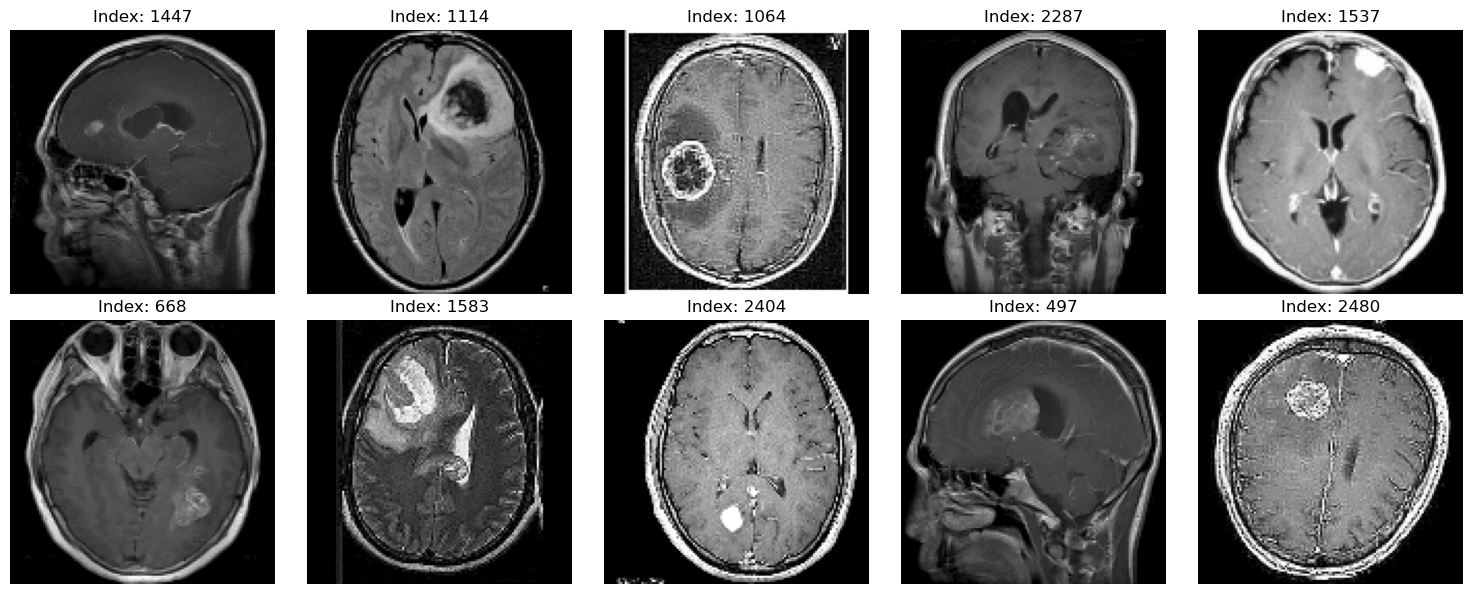

In [39]:
sampled_indices = idf.sample(n=10, random_state=42).index
display_images_in_grid(idf, sampled_indices)

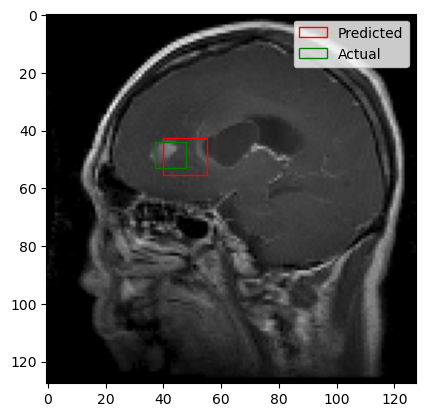

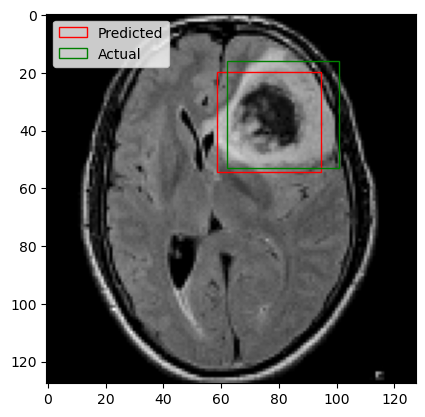

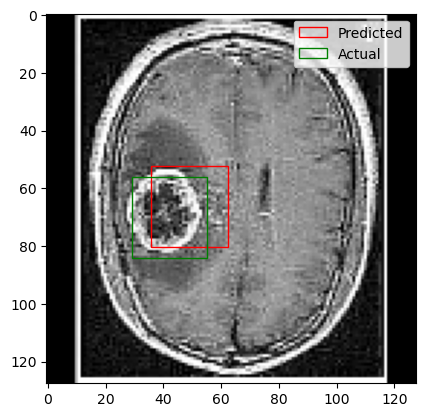

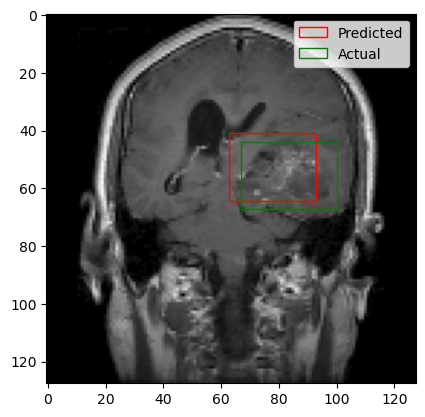

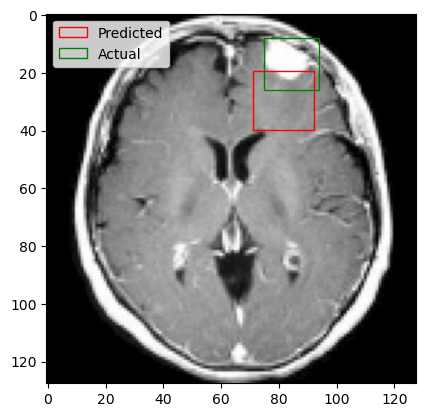

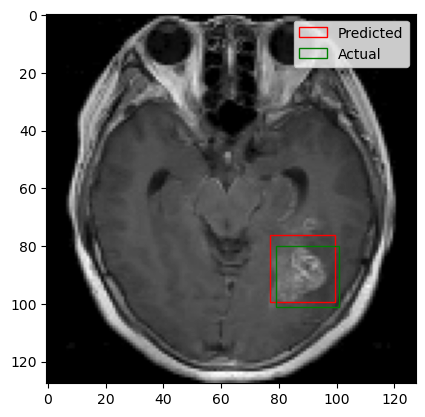

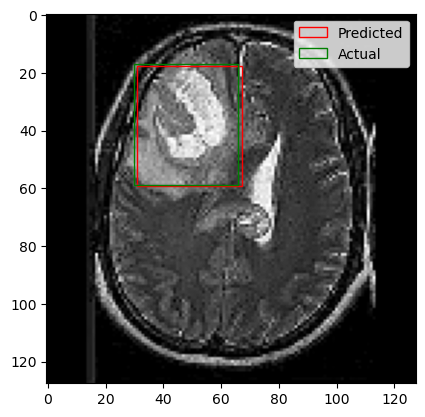

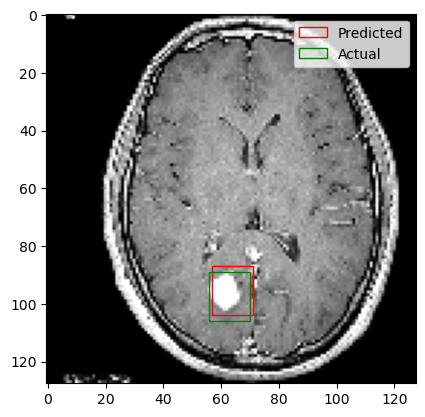

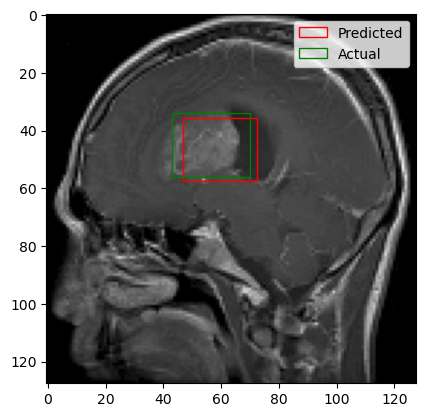

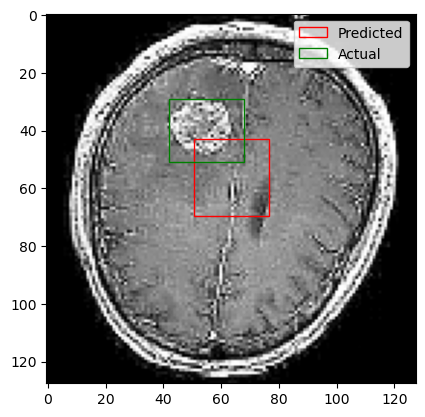

In [88]:
# Get the corresponding images and their actual bounding boxes
sampled_images = image_data[sampled_indices]
actual_bboxes = y[sampled_indices]


sampled_images_flat = sampled_images.reshape(sampled_images.shape[0], -1) # Flatten sampled images for prediction
sampled_images_reduced = pca.transform(sampled_images_flat) # Apply PCA transformation to sampled images
predicted_bboxes = best_rf.predict(sampled_images_reduced) # Predict bounding boxes using best model

# Visualize each sampled image with its predicted and actual bounding boxes
for i, idx in enumerate(sampled_indices): # adds a counter to an iterable and returns it as an enumerate object.
    image = sampled_images[i].reshape(128, 128)
    pred_bbox = predicted_bboxes[i]
    actual_bbox = actual_bboxes[i]
    visualize_image_comparison(image, pred_bbox, actual_bbox)


### Conclusion:

This approach is not very effective, nice to have tried. 
I must dive into other approaches and comprehend image analysis from pixels and how to best organize.
This prediction has overfitting issues and needs better image pre-processing to be most effective.

For next time,
Learn cordinates of an image scan and learn pattern with in it,
organize images similar to its layout (scan of top of head, side of head, etc.) then train models of each of those sub levels. 

In [43]:
# Work in Progress.